In [6]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from skimage.filters import gaussian
from vacation.data import GalaxyDataset
from tqdm import tqdm
import torchvision.transforms as T 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [2]:
train_ds = GalaxyDataset(
    path="../../.data/Galaxy10_DECals_train.h5",
    device="cuda",
    max_cache_size="7G",
    cache_loaded=False,
)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
valid_ds = GalaxyDataset(
    path="../../.data/Galaxy10_DECals_valid.h5",
    device="cuda",
    max_cache_size="2G",
    cache_loaded=False,
)

In [4]:
from torch.utils.data import Subset

n_train = 16000
n_val = 1000

np.random.seed(42)


train_indices = [int(i) for i in np.random.choice(len(train_ds), n_train, replace=False)]
val_indices = [int(i) for i in np.random.choice(len(valid_ds), n_val, replace=False)]
train_small = Subset(train_ds, train_indices)
val_small = Subset(valid_ds, val_indices)


In [5]:
gaussian_filter = T.GaussianBlur(3,sigma=1.0)

In [10]:
def hog_features(df, length = None ,pixels_per_cell = (12,12) ,visualize = False):

    if length == None:
        n = len(df)
    else: 
        n = length

    #example image to see the effect of HOG and the filter 
    sample_image = df[0][0]
    sample_image = gaussian_filter(sample_image).permute(1,2,0).cpu().numpy()

    sample_fd, sample_image = hog(
        sample_image,
        orientations=9,
        pixels_per_cell=pixels_per_cell, 
        cells_per_block=(2, 2),
        visualize=True,
        channel_axis=-1
    )

    #initialisation of feature vector
    X = np.zeros((n, sample_fd.shape[0]), dtype=np.float32)
    y = np.zeros(n, dtype=np.int64)

    
    for i in tqdm(range(n)):
        image_tensor, label = df[i]
        image_np = gaussian_filter(image_tensor).permute(1,2,0).cpu().numpy()
        fd = hog(
            image_np,
            orientations=9,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=(2, 2),
            visualize=visualize,
            channel_axis=-1
        )
        X[i] = fd
        y[i] = label
    return X,y, sample_image

In [11]:
X_train, y_train, example_image = hog_features(train_ds)

100%|██████████| 16813/16813 [50:27<00:00,  5.55it/s]


In [16]:
len(valid_ds)

4204

In [17]:
X_val, y_val, _ = hog_features(valid_ds)

100%|██████████| 4204/4204 [12:29<00:00,  5.61it/s]


In [3]:
#np.save("rf_features_train.npy",X_train)
#np.save("rf_labels_train",y_train)

np.save("rf_features_valid.npy",X_val)
np.save("rf_labels_valid.npy",y_val)

NameError: name 'X_val' is not defined

In [4]:
X_train = np.load("rf_features_train.npy")
y_train = np.load("rf_labels_train.npy")

X_val = np.load("rf_features_valid.npy")
y_val = np.load("rf_labels_valid.npy")

In [4]:
rf = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 30,
    n_jobs = -1,
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.38      0.34       413
           1       0.48      0.19      0.28       425
           2       0.64      0.87      0.74       423
           3       0.54      0.68      0.60       423
           4       0.58      0.83      0.68       419
           5       0.51      0.41      0.45       419
           6       0.42      0.32      0.37       426
           7       0.40      0.26      0.32       420
           8       0.60      0.76      0.67       413
           9       0.53      0.45      0.48       423

    accuracy                           0.51      4204
   macro avg       0.50      0.51      0.49      4204
weighted avg       0.50      0.51      0.49      4204



In [37]:
y_train_pred = rf.predict(X_train)

In [38]:
print(np.unique(y_val, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([413, 425, 423, 423, 419, 419, 426, 420, 413, 423]))


In [39]:
accuracy = accuracy_score(y_val,y_pred)
cm = confusion_matrix(y_val,y_pred)

In [40]:
print(accuracy,"on validation")
print(accuracy_score(y_train,y_train_pred),"on train")

0.5214081826831589 on validation
0.998750966514007 on train


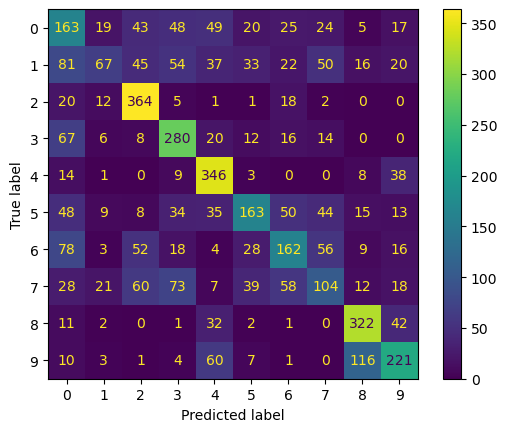

In [41]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [9]:
RF = RandomForestClassifier()

param_dist = {"n_estimators": randint(50,400),
              "max_features": ["sqrt","log2", None],
              "max_depth": randint(1,20),
              "min_samples_split": randint(2,10),
              "min_samples_leaf": randint(1,2),
              }

rand_search = RandomizedSearchCV(RF,
                                 param_distributions = param_dist,
                                 n_iter = 5, 
                                 cv = 5,
                                 n_jobs = -1,
                                 verbose = 1
                                )

rand_search.fit(X_train, y_train)

SyntaxError: invalid non-printable character U+00A0 (2417311039.py, line 7)

In [52]:
best_rf = rand_search.best_estimator_
print("Best hyperparameters are:", rand_search.best_params_)

Best hyperparameters are: {'max_depth': 13, 'n_estimators': 305}


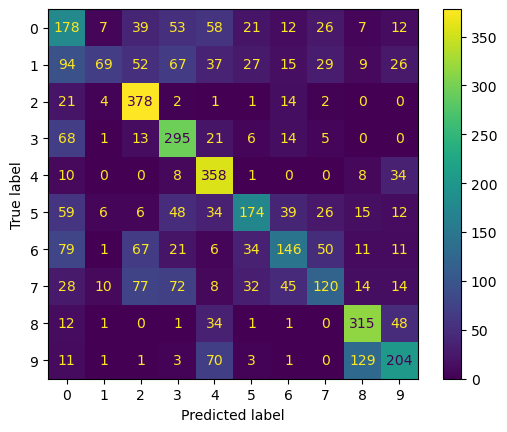

In [56]:
y_pred = best_rf.predict(X_val)

cm = confusion_matrix(y_val,y_pred)

ConfusionMatrixDisplay(cm).plot()

In [57]:
print("accuracy on validation set after hyperparameter optimization",accuracy_score(y_val,y_pred))

accuracy on validation set after hyperparameter optimization 0.5321122740247384


[   0    1    2 ... 4197 4199 4201]


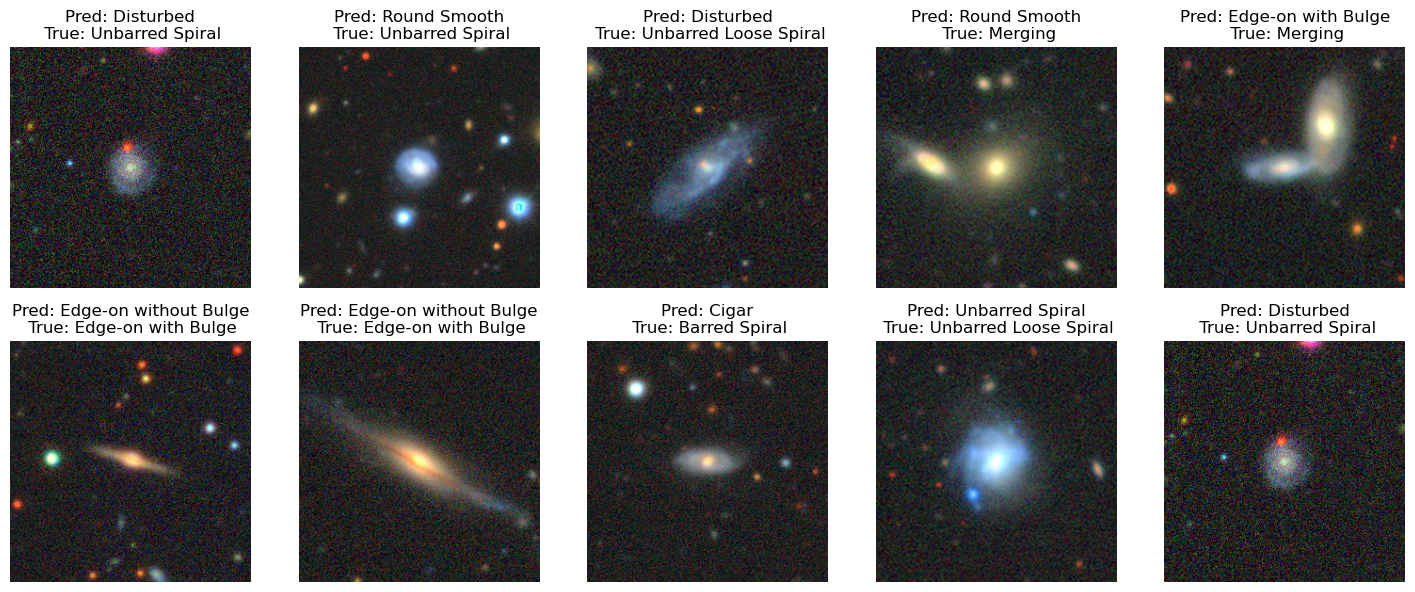

In [83]:
misclassified_indices = np.where(y_pred != y_val)[0]
print(misclassified_indices)
misclassified = np.random.choice(misclassified_indices,10)

class_names = ["Disturbed","Merging","Round Smooth","In-between","Cigar","Barred Spiral","Unbarred Spiral","Unbarred Loose Spiral","Edge-on without Bulge","Edge-on with Bulge"]

fig, axes = plt.subplots(2, 5, figsize=(18,7))
for i, ax in enumerate(axes.flat):
    idx = misclassified[i]
    image = valid_ds[int(idx)][0].permute(1,2,0).cpu().numpy()

    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Pred: {class_names[y_pred[int(idx)]]}\n True: {class_names[y_val[int(idx)]]}")






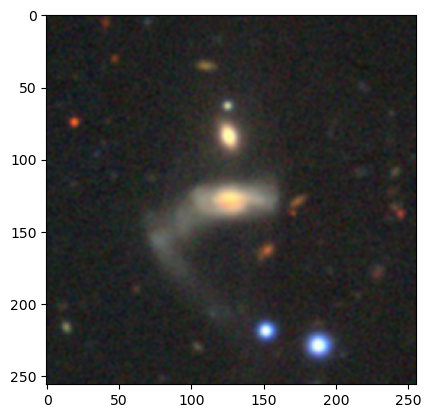

In [199]:
plt.imshow(gaussian_filter(train_ds[0][0]).permute(1,2,0).cpu())

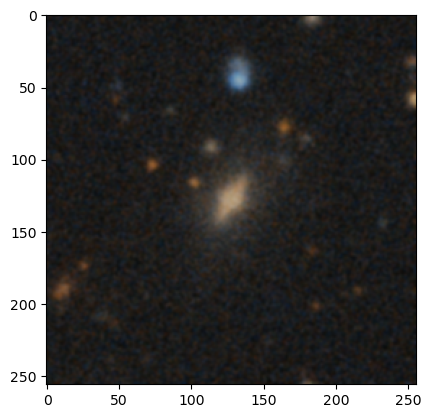

In [176]:
plt.imshow(gaussian(train_ds[16500][0].permute(1,2,0).cpu()))

In [15]:
image = train_ds[16500][0].permute(1,2,0).cpu()
image = gaussian(image,sigma=1.0)
fd, hog_image = hog(
    image,
    orientations=9,
    pixels_per_cell=(12, 12),
    cells_per_block=(1, 1),
    block_norm ='L1',
    visualize=True,
    channel_axis=-1,
)


In [16]:
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

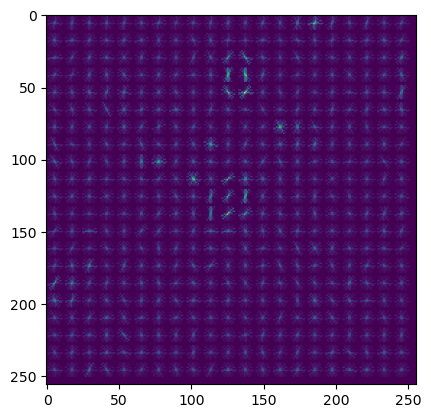

In [17]:
plt.imshow(hog_image_rescaled)